In [ ]:
import os
import numpy as np
import cv2
import pathlib, random
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("drive mounted")

Mounted at /content/drive
drive mounted


In [ ]:
data_path = "/content/drive/MyDrive/food-items"
categories = os.listdir(data_path)

print(f"Found {len(categories)} categories:\n")
for category in categories:
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f"{category}: {num_images} images")


Found 3 categories:

waffles: 1000 images
baklava: 1000 images
pizza: 1000 images


In [ ]:
random.seed(42)

original_dir = pathlib.Path("/content/drive/MyDrive/food-items")
new_base_dir = pathlib.Path("/content/drive/MyDrive/food-seg")
categories = [d for d in os.listdir(original_dir) if os.path.isdir(original_dir / d)]

def make_subset(subset_name, start_ratio, end_ratio):
    for category in categories:
        src_dir = original_dir / category
        dest_dir = new_base_dir / subset_name / category

        # Clear existing dest_dir to avoid duplicates
        if os.path.exists(dest_dir):
            shutil.rmtree(dest_dir)
        os.makedirs(dest_dir, exist_ok=True)

        images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        start_idx = int(start_ratio * total)
        end_idx = int(end_ratio * total)

        for fname in images[start_idx:end_idx]:
            shutil.copyfile(src=src_dir / fname, dst=dest_dir / fname)

        print(f"{subset_name}/{category}: {end_idx - start_idx} images copied.")

make_subset("train", 0.0, 0.7)
make_subset("validation", 0.7, 0.85)
make_subset("test", 0.85, 1.0)

train/waffles: 700 images copied.
train/baklava: 700 images copied.
train/pizza: 700 images copied.
validation/waffles: 150 images copied.
validation/baklava: 150 images copied.
validation/pizza: 150 images copied.
test/waffles: 150 images copied.
test/baklava: 150 images copied.
test/pizza: 150 images copied.


In [ ]:
selected_categories = ['waffles', 'baklava', 'pizza']

img_size = 224

def get_data(data_dir):
    images = []
    image_labels = []
    for class_num, label in enumerate(selected_categories):
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]  # Convert BGR to RGB
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                image_labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(images), np.array(image_labels)


In [ ]:
data_base_dir = "/content/drive/MyDrive/food-seg"

train_images, train_labels = get_data(os.path.join(data_base_dir, 'train'))
val_images, val_labels = get_data(os.path.join(data_base_dir, 'validation'))

In [ ]:
print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Unique training labels:", np.unique(train_labels))
print("Number of classes:", len(selected_categories))

Train images shape: (2100, 224, 224, 3)
Validation images shape: (450, 224, 224, 3)
Unique training labels: [0 1 2]
Number of classes: 3


In [ ]:
x_train = train_images.astype('float32') / 255.0
x_val = val_images.astype('float32') / 255.0

num_classes = len(selected_categories)

y_train = to_categorical(train_labels, num_classes)
y_val = to_categorical(val_labels, num_classes)


assert y_train.shape[1] == num_classes, "Mismatch in number of classes"

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True, seed=42)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32, shuffle=False)


In [ ]:
print(f"Training samples: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")

Training samples: 2100
Validation samples: 450


In [ ]:
num_classes = len(selected_categories)

mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mobilenet_base.layers:
    layer.trainable = False

model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
model_ckpt = ModelCheckpoint(
    filepath='/content/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, model_ckpt],
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.88444, saving model to /content/best_model.keras
66/66 - 53s - 804ms/step - accuracy: 0.6705 - loss: 0.8490 - val_accuracy: 0.8844 - val_loss: 0.3535
Epoch 2/25

Epoch 2: val_accuracy improved from 0.88444 to 0.91111, saving model to /content/best_model.keras
66/66 - 27s - 404ms/step - accuracy: 0.8252 - loss: 0.4711 - val_accuracy: 0.9111 - val_loss: 0.2440
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.91111
66/66 - 26s - 394ms/step - accuracy: 0.8705 - loss: 0.3437 - val_accuracy: 0.9111 - val_loss: 0.2076
Epoch 4/25

Epoch 4: val_accuracy improved from 0.91111 to 0.93333, saving model to /content/best_model.keras
66/66 - 30s - 449ms/step - accuracy: 0.8871 - loss: 0.3091 - val_accuracy: 0.9333 - val_loss: 0.1820
Epoch 5/25

Epoch 5: val_accuracy improved from 0.93333 to 0.93778, saving model to /content/best_model.keras
66/66 - 24s - 370ms/step - accuracy: 0.8919 - loss: 0.2865 - val_accuracy: 0.9378 - val_loss: 0.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,254,347 (12.41 MB)

 Trainable params: 331,267 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

 Optimizer params: 662,536 (2.53 MB)

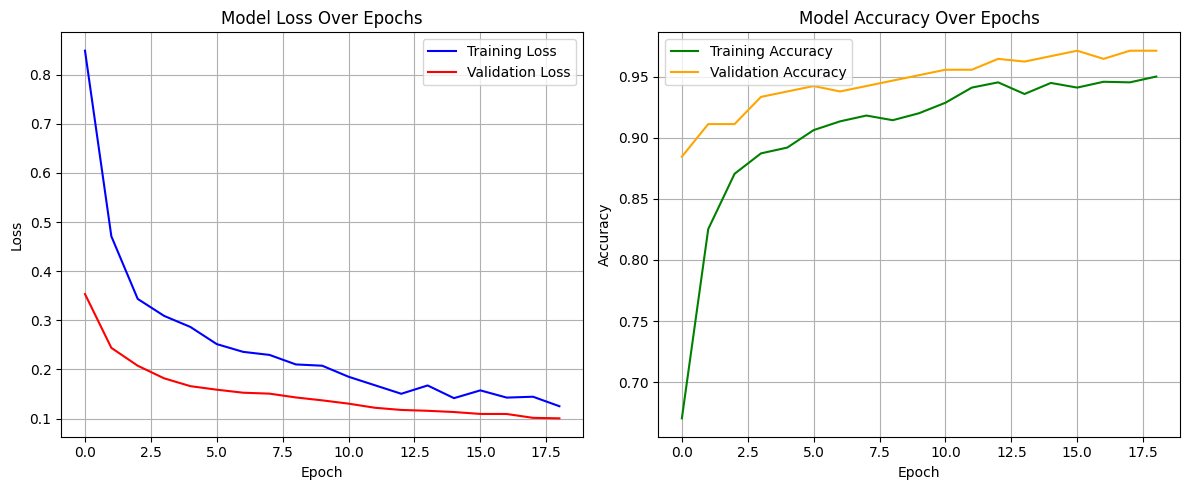

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss Over Epochs')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred_probs = model.predict(x_val, verbose=1) # Predict directly on x_val
y_pred = np.argmax(y_pred_probs, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step


In [ ]:
y_true = val_labels

In [ ]:
labels = selected_categories

In [ ]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9711


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

     waffles       0.97      0.95      0.96       150
     baklava       0.96      0.99      0.97       150
       pizza       0.99      0.97      0.98       150

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



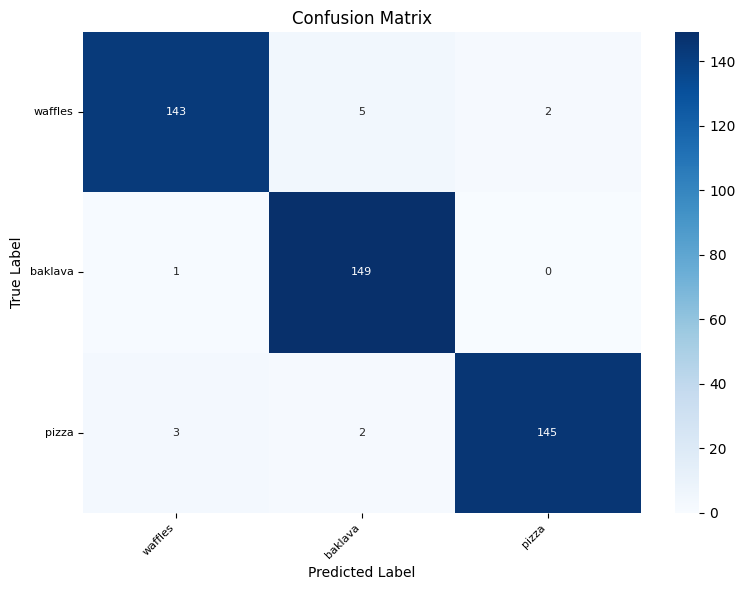

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))  # Reduced from (14, 12)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 8})
plt.title("Confusion Matrix", fontsize=12)
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

Saving waffle.webp to waffle (1).webp
Saving baklava.png to baklava (1).png
Saving pizza.jpg to pizza (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


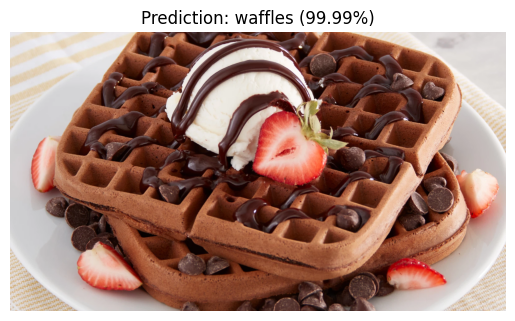

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


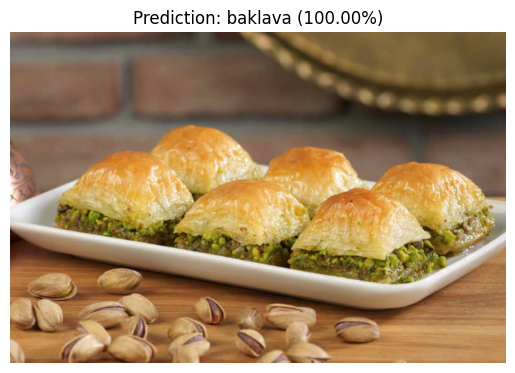

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


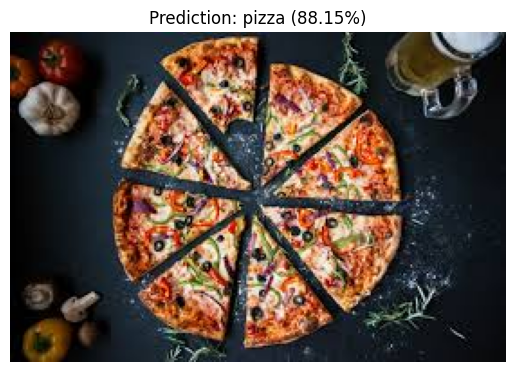

In [ ]:
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()

from tensorflow.keras.models import load_model
model = load_model('/content/best_model.keras')

class_labels = ['waffles', 'baklava', 'pizza']

img_size = 224

def preprocess_image(image):
    image = image.resize((img_size, img_size))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

for file_name in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[file_name])).convert('RGB')

    processed_image = preprocess_image(image)

    predictions = model.predict(processed_image)
    predicted_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index] * 100

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.show()